### Theano

多次元配列（テンソル）を用いた数式の実装、コンパイル、評価を効率よく行うための機能

In [1]:
# 単純な利用例
import theano
from theano import tensor as T

# 初期化：scalarメソッドで、スカラ＝単純な配列を生成
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
# 1. 数式を定義
z1 = w0 + w1 * x1

# 2. 数式をコンパイル
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 3. 実行
print('Net input: %.2f' % net_input(2.0, 1.0, 0.5))

Net input: 2.50


In [2]:
# Theanoの設定変更の方法
print(theano.config.floatX)
print(theano.config.device)

float64
cpu


In [3]:
theano.config.floatX = 'float32'

In [4]:
print(theano.config.floatX)

float32


In [5]:
# 配列構造の操作
import numpy as np

# 初期化
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# コンパイル
cals_sum = theano.function(inputs=[x], outputs=x_sum)

# 実行(Pythonリスト、Numpy配列の両方で操作可能)
ary = [[1,2,3], [1,2,3]]
print('Column sum: %s' % cals_sum(ary))

ary = np.array([[1,2,3], [1,2,3]], dtype=theano.config.floatX)
print('Column sum: %s' % cals_sum(ary))

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]


In [6]:
# 共有変数の設定と操作
# 初期化
x = T.fmatrix('x')
w = theano.shared(np.array([[0.0, 0.0, 0.0]], dtype=theano.config.floatX)) # 共有要素
z = x.dot(w.T)
update = [[w, w + 1.0]] # forループを繰り返すたびに各要素に1を加算

# コンパイル
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# 実行
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

('z0:', array([[ 0.]], dtype=float32))
('z1:', array([[ 6.]], dtype=float32))
('z2:', array([[ 12.]], dtype=float32))
('z3:', array([[ 18.]], dtype=float32))
('z4:', array([[ 24.]], dtype=float32))


In [7]:
# givens引数を利用し、共有変数を使う処理を高速化
# 初期化
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.array([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# 実行
for i in range(5):
    print('z%d:' % i, net_input())

('z0:', array([[ 0.]], dtype=float32))
('z1:', array([[ 6.]], dtype=float32))
('z2:', array([[ 12.]], dtype=float32))
('z3:', array([[ 18.]], dtype=float32))
('z4:', array([[ 24.]], dtype=float32))


In [8]:
# 最小２乗法線形回帰
# トレーニングデータセット
X_train = np.array([[0.0], [1.0],
                    [2.0], [3.0],
                    [4.0], [5.0],
                    [6.0], [7.0],
                    [8.0], [9.0]],
                    dtype=theano.config.floatX)
y_train = np.array([1.0, 1.3,
                    3.1, 2.0,
                    5.0, 6.3,
                    6.6, 7.4,
                    8.0, 9.0],
                    dtype=theano.config.floatX)

In [9]:
# トレーニング関数の実装
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):
    
    costs = []
    # theano用の配列の初期化
    eta0 = T.fscalar('eta0') # float32型のスカラのインスタンス
    y = T.fvector(name='y')  # float32型のベクトルのインスタンス
    X = T.fmatrix(name='X')  # float32型の行列のインスタンス
    # 重みwを共有変数として作成
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1),
                               dtype=theano.config.floatX),
                      name='w')
    
    # コストの計算
    net_input = T.dot(X, w[1:]) + w[0]  # 重みを用いて総入力を計算（w0はバイアスユニット用）
    errors = y - net_input              # yと総入力の誤差
    cost = T.sum(T.pow(errors, 2))      # 誤差の２乗和
    
    # 重みの更新
    gradient = T.grad(cost, wrt=w)      # gradはcostをwrtで渡されたwについて微分する
    update = [(w, w - eta0 * gradient)] # 学習率を掛けて重みを更新
    
    # モデルをコンパイル
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X: X_train, y: y_train})
    
    for _ in range(epochs):
        costs.append(train(eta))
        
    return costs, w

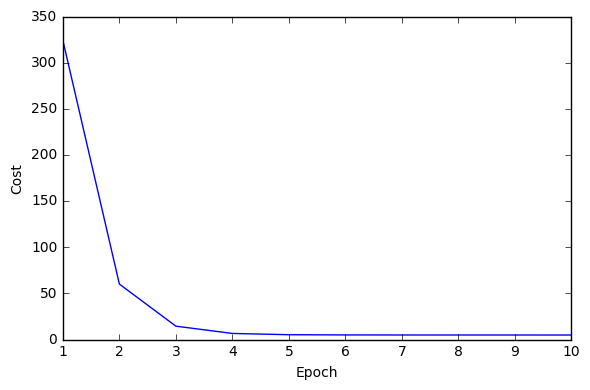

In [10]:
# 学習結果を可視化
import matplotlib.pyplot as plt
costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

In [11]:
# 予測用の関数
def predict_linreg(X, w):
    # 初期化
    Xt = T.matrix(name='X')
    # 定義
    net_input = T.dot(Xt, w[1:]) + w[0]
    # コンパイル
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    # 実行
    return predict(X)

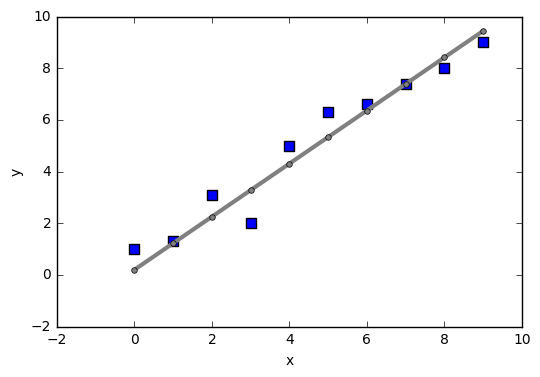

In [12]:
# 予測の可視化
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w), color='gray', marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### フィードフォワードニューラルネットワークでの活性化関数の選択

ロジスティック関数はニューロンの概念をある程度表現しており、その出力はニューロンが発火するかどうかの確率として考えることができる<br>
が、入力に負の度合いが多く、関数の出力が0に近い場合、微分係数が小さい→進み幅が少ないので、学習に非常に時間がかかり、
かつ、局所的な最小値にはまりやすいという欠点がある<br>
そのため、隠れ層の活性化関数には双曲線正接（tanh）関数が使われることがある

#### 活性化関数1 ロジスティック関数

In [13]:
# ロジスティック関数の復習
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    return X.dot(w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    return logistic(net_input(X, w))

# このサンプルが陽性クラスに属する確率は0.707
print('P=(y=1|x) = %.3f' % logistic_activation(X, w))

P=(y=1|x) = 0.707


In [14]:
# ロジスティック活性化ユニットが複数の場合、合計が100%になるわけではないので関数のアウトプットがわかりづらい
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

A = np.array([[1.0],
              [0.1],
              [0.3],
              [0.7]])

Z = W.dot(A)
y_probas = logistic(Z)
print('Probabilities:\n %s\n' % y_probas)

# 確率の最も高いものを返す　という予測のみのアウトプットであればそこまでわかりづらくはない
y_class = np.argmax(z, axis=0)
print('Predicted class label: %s' % y_class[0])

Probabilities:
 [[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]

Predicted class label: Subtensor{int64}.0


#### 活性化関数2 ソフトマックス関数

ロジスティック回帰の一般化であり、多クラス分類問題において、各クラスへの所属確率を計算できる<br>
この関数では以下の通り、zのときiに所属する出力値を、全ての出力値の和で割って、正規化している<br>
$$
P(y=i|z) = \phi_{softmax}(z) = \frac{e^{z}_{i}}{\sum^M_{m=1}e^z_m}
$$

予測するクラスラベルはロジスティック関数と同じになるので、正規化されたロジスティック関数と考えると良いかもしれない

In [15]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    return softmax(net_input(X, w))

y_probas = softmax(Z)
print('Probabilities: \n %s' % y_probas)
# 出力される確率の合計は1
y_probas.sum()

Probabilities: 
 [[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


1.0

In [16]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class[0])

Predicted class label: 2


#### 活性化関数3 双曲線正接関数

双曲線正接関数はロジスティック関数の尺度をとりなおしたバージョンとして解釈できる<br>
最大値を2倍に、最小値を0から-1に引き下げ（範囲-1〜1に）、インプットの単位当たりの関数出力も2倍に（収束が早まる）
$$
\phi_{tahh}(z) = 2 \times \frac{1}{1 + e^{-(2 \times z)}} - 1 = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$
利点としてはロジスティック関数より出力範囲が広く（-1〜1）、収束の速度を早めることができるという点がある

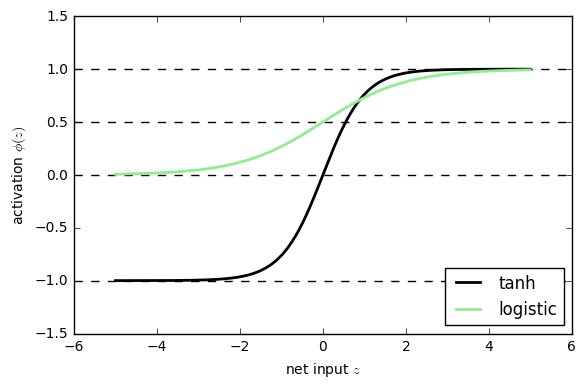

In [17]:
# 双曲線正接とロジスティックをプロットして比較
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [18]:
# numpy にtanh関数がある
tanh_act = np.tanh(z)
# scipyにロジスティック関数がある
from scipy.special import expit
log_act = expit(z)

#### keras

In [19]:
# データ読み込み
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """MNISTデータをpathからロードする"""
    # 引数に渡したパスとファイル名を結合し、フルパスを生成
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # ラベルファイル読み込み
    # openにファイルパスとバイナリ読み込みモード指定
    with open(labels_path, 'rb') as lbpath:
        # unpackでバイナリを文字列に変換 先頭8バイトはマジックナンバーとアイテムの個数
        magic, n = struct.unpack('>II', lbpath.read(8))
        # fromfileで配列のデータ形式を指定して配列を作成
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    # 画像ファイル読み込み
    # 構造：サンプル数 ×　グレースケールの輝度（28×28=784次元）
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [20]:
# データ読み込み
X_train, y_train = load_mnist('mnist')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [21]:
# データを32ビット形式に変換
import theano
theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

In [22]:
# one-hotフォーマットに変換
from keras.utils import np_utils
print('First 3 labels: %s' % y_train[:3])
y_train_ohe = np_utils.to_categorical(y_train)
print('First 3 labels: %s' % y_train_ohe[:3])

Using TensorFlow backend.


First 3 labels: [5 0 4]
First 3 labels: [[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [23]:
# モデルを作成
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD     # 確率的勾配降下法

np.random.seed(1)

model = Sequential()                             # モデルを初期化

# 1つ目の隠れ層を追加
model.add(Dense(input_dim=X_train.shape[1],      # 入力ユニット数（特徴量の次元数）
                units=50,                        # 出力ユニット数
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                activation='tanh'))              # 活性化関数を双曲線正接関数に指定

# 2つ目の隠れ層を追加
model.add(Dense(input_dim=50,                    # 入力ユニット数（1つ前の出力ユニット数に合わせる）
                units=50,                        # 出力ユニット数
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                activation='tanh'))              # 活性化関数を双曲線正接関数に指定

# 出力層を追加
model.add(Dense(input_dim=50,                    # 入力ユニット数（つ前の出力ユニット数に合わせる）
                units=y_train_ohe.shape[1],      # 出力ユニット数 (クラスラベル数に合わせる)
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                activation='softmax'))           # 活性化関数を双曲線正接関数に指定

# モデルコンパイル時に指定するオプティマイザを指定
# 引数に、学習率、学習率の減衰率、モーメンタム学習の定数を設定
sgd = SGD(lr=0.001, decay=1e-7, momentum=0.9)

# モデルをコンパイル
model.compile(loss='categorical_crossentropy', # コスト関数 カテゴリ交差エントロピー
              optimizer='sgd',                 # オプティマイザ
              metrics=['accuracy'])            # モデルの評価指標

In [24]:
# fit
model.fit(X_train,               # トレーニングデータ
          y_train_ohe,           # 出力データ
          epochs=50,             # トレーニング回数
          batch_size=300,        # 更新を行うミニバッチサイズ
          verbose=1,             # 実行状況を表示
          validation_split=0.1)  # 過学習の検証用にデータを保持、学習後にチェック

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s - loss: 2.2040 - acc: 0.4486 - val_loss: 2.0440 - val_acc: 0.6277
Epoch 2/50
54000/54000 [==============================] - 1s - loss: 1.7640 - acc: 0.6238 - val_loss: 1.4397 - val_acc: 0.6580
Epoch 3/50
54000/54000 [==============================] - 1s - loss: 1.2500 - acc: 0.6708 - val_loss: 1.0366 - val_acc: 0.7450
Epoch 4/50
54000/54000 [==============================] - 1s - loss: 0.9503 - acc: 0.7599 - val_loss: 0.7957 - val_acc: 0.8143
Epoch 5/50
54000/54000 [==============================] - 1s - loss: 0.7573 - acc: 0.8196 - val_loss: 0.6376 - val_acc: 0.8625
Epoch 6/50
54000/54000 [==============================] - 1s - loss: 0.6331 - acc: 0.8521 - val_loss: 0.5418 - val_acc: 0.8828
Epoch 7/50
54000/54000 [==============================] - 1s - loss: 0.5481 - acc: 0.8699 - val_loss: 0.4642 - val_acc: 0.9007
Epoch 8/50
54000/54000 [==============================] - 1s -

In [25]:
# 予測カテゴリを取得
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: %s' % y_train_pred[:3])

First 3 predictions: [5 0 4]


In [26]:
# トレーニングデータとテストデータで正解率を出力
train_acc = np.sum(y_train == y_train_pred, axis=0) / (X_train.shape[0] * 1.0) # サンプル数
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / (X_test.shape[0] * 1.0) # サンプル数
print('Test accuracy: %.2f%%' % (test_acc * 100))

Training accuracy: 94.00%
Test accuracy: 93.61%


#### kaggleのデータで試してみる

In [24]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

X_train2 = train.ix[:, 1:].values
y_train2 = train.ix[:, 0].values
X_test2 = test.values

X_train2 = X_train2.astype(theano.config.floatX)
X_test2 = X_test2.astype(theano.config.floatX)

y_train_ohe2 = np_utils.to_categorical(y_train2)

In [48]:
from keras.regularizers import l2

np.random.seed(1)

model2 = Sequential()                             # モデルを初期化

# 1つ目の隠れ層を追加
model2.add(Dense(input_dim=X_train2.shape[1],    # 入力ユニット数（特徴量の次元数）
                units=500,                        # 出力ユニット数
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                kernel_regularizer=l2(0.001),     # 重みをL2正則化
                activation='tanh'))              # 活性化関数を双曲線正接関数に指定

# 2つ目の隠れ層を追加
model2.add(Dense(input_dim=500,                   # 入力ユニット数（1つ前の出力ユニット数に合わせる）
                units=500,                        # 出力ユニット数
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                kernel_regularizer=l2(0.001),     # 重みをL2正則化       
                activation='tanh'))              # 活性化関数を双曲線正接関数に指定

# 出力層を追加
model2.add(Dense(input_dim=500,                   # 入力ユニット数（つ前の出力ユニット数に合わせる）
                units=y_train_ohe.shape[1],      # 出力ユニット数 (クラスラベル数に合わせる)
                kernel_initializer='uniform',    # 重みの初期化（一様乱数）
                activity_regularizer=l2(0.001),
                activation='softmax'))           # 活性化関数を双曲線正接関数に指定

# モデルコンパイル時に指定するオプティマイザを指定
# 引数に、学習率、学習率の減衰率、モーメンタム学習の定数を設定
sgd = SGD(lr=0.0005, decay=1e-7, momentum=0.9)

# モデルをコンパイル
model2.compile(loss='categorical_crossentropy', # コスト関数 カテゴリ交差エントロピー
              optimizer='sgd',                  # オプティマイザ
              metrics=['accuracy'])             # モデルの評価指標

In [49]:
# fit
model2.fit(X_train2,               # トレーニングデータ
           y_train_ohe2,           # 出力データ
           epochs=100,              # トレーニング回数
           batch_size=300,         # 更新を行うミニバッチサイズ
           verbose=1,              # 実行状況を表示
           validation_split=0.1)   # 過学習の検証用にデータを保持、学習後にチェック

Train on 37800 samples, validate on 4200 samples
Epoch 1/100
37800/37800 [==============================] - 5s - loss: 1.8099 - acc: 0.7384 - val_loss: 1.3656 - val_acc: 0.8640
Epoch 2/100
37800/37800 [==============================] - 5s - loss: 1.2738 - acc: 0.8736 - val_loss: 1.2018 - val_acc: 0.8917
Epoch 3/100
37800/37800 [==============================] - 5s - loss: 1.1656 - acc: 0.8981 - val_loss: 1.1408 - val_acc: 0.9062
Epoch 4/100
37800/37800 [==============================] - 5s - loss: 1.1127 - acc: 0.9102 - val_loss: 1.1068 - val_acc: 0.9100
Epoch 5/100
37800/37800 [==============================] - 5s - loss: 1.0795 - acc: 0.9179 - val_loss: 1.0834 - val_acc: 0.9164
Epoch 6/100
37800/37800 [==============================] - 5s - loss: 1.0546 - acc: 0.9255 - val_loss: 1.0670 - val_acc: 0.9176
Epoch 7/100
37800/37800 [==============================] - 6s - loss: 1.0348 - acc: 0.9304 - val_loss: 1.0504 - val_acc: 0.9212
Epoch 8/100
37800/37800 [==============================

In [46]:
y_train_pred2 = model2.predict_classes(X_train2, verbose=0)
train_acc2 = np.sum(y_train2 == y_train_pred2, axis=0) / (X_train2.shape[0] * 1.0) # サンプル数
print('Training accuracy: %.2f%%' % (train_acc2 * 100))

Training accuracy: 98.88%


In [47]:
# 結果を保存
submission = pd.DataFrame({
        'ImageId': test.index.values + 1,
        'Label': model2.predict_classes(X_test2, verbose=0).astype(int)
    })
submission.to_csv('result/predict_nn.csv', index=False)